# Instructions

1. This assignment is worth 5% of the final grade.
2. In the questions below, insert a cell (code or markdown, as appropriate), and fill in your answers there.
2. You are required to work on this individually. Any form of plagiarism will result in 0.
3. Please submit your notebook file (name it `IND5003_A2_<Your_Name>.ipynb`) through Canvas before **17th Nov 2023 23:59hrs**.

Content:
* [Question 1](#Question-1)
    * [Question 1 Part 1](#Question-1-Part-1)
    * [Question 1 Part 2](#Question-1-Part-2)
* [Question 2](#Question-2)
    * [Question 2 Part 1](#Question-2-Part-1)
    * [Question 2 Part 2](#Question-2-Part-2)

## Question 1

In Python, you can save a binary version of an object by pickling it. The file `IND5003_2310_Assignment2.pickle` contains the training and test data that we used in class for the KNN model. The pickle was created in this way:

To read pickled objects into your notebook, you can do this:

In [1]:
# import pickle

# with open('../data/IND5003_2310_Assignment2.pickle', 'rb') as f:
#     X_ttrain, X_ttest, y_train, y_test = pickle.load(f)

If this does not work for you, run the following cell to obtain `X_ttrain`, `X_ttest`, `y_train`, `y_test`.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn import set_config
set_config(display='diagram')

In [3]:
set_config(display='diagram')

loans = pd.read_excel('../data/loans.xlsx', index_col=0)
loans.loc[:, 'issue_yr'] = loans.issue_d.apply(lambda x: x.year)
loans.loc[:, 'issue_mth'] = loans.issue_d.apply(lambda x: x.month)
drop_these_columns = loans.apply(lambda x: np.sum(pd.notna(x)), axis=0) < 40000
loans.drop(columns=loans.columns[drop_these_columns], inplace=True)
no_miss = loans[pd.notna(loans).all(axis=1)].copy()
cr_line_cols = no_miss.earliest_cr_line.str.split('-', expand=True)
cr_line_cols.columns = ['ecrl_mth', 'ecrl_yr']
cr_line_cols.ecrl_yr = cr_line_cols.ecrl_yr.astype(int)
no_miss = pd.concat([no_miss, cr_line_cols], axis=1)
y = no_miss.y
X_train, X_test, y_train, y_test = train_test_split(no_miss, y, test_size=0.3, random_state=41, stratify=y)

num_features = ['loan_amnt', 'int_rate', 'installment', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'issue_yr']
cat_features = ['term', 'grade', 'emp_length', 'home_ownership', 'loan_status', 'purpose', 'addr_state']
all_features = num_features + cat_features
X_train = X_train.loc[:, all_features]
X_test = X_test.loc[:, all_features]
ct = ColumnTransformer([
      ('scale', StandardScaler(), make_column_selector(dtype_include=np.number)),
      ('onehot', OneHotEncoder(), make_column_selector(dtype_include=object))])
ct.fit(X_train)
X_ttrain = ct.transform(X_train)
X_ttest = ct.transform(X_test)

1. A logistic regression classifier is a widely used classification model. It models the log-odds for a class as a linear combination of one or more independent variables. **With L2 regularization,** the hyper-parameter is C, the inverse of regularization strength. Create a sklearn logistic regression classifier with L2 regularization, `random_state=42` and `solver='saga'`, then generate and plot the validation curve by varying C over the range from 1 to 3001 (inclusive of both endpoints) with at least 16 different values.
2. Apply the best estimator to the *test set*, and compare the confusion matrix to the KNN model. In class, it achieved an accuracy of 0.89 and an F1-score of 0.58.

### Question 1 Part 1

Data is already scaled and encoded.  

Steps:   
1. Find 16 values of C, starting from 1, ending at 3001.  
2. Build the logistic regression object with `L2 regularization`, `random_sate=42` and `solver='saga'`.   
3. Use validation curve to find the train and test scores.  
4. Plot the results.   
5. Find the best value for C.   

In [4]:
# Setting the range for C
C_range = np.linspace(1, 3001, 16)

In [5]:
# Creating logistic regression classifier with L2 regularization
log_reg = LogisticRegression(random_state=42, solver='saga', penalty='l2', max_iter=100000)

In [6]:
# Generating validation curve
train_scores, test_scores = validation_curve(
    log_reg, X_ttrain, y_train, param_name="C", param_range=C_range, cv=5, scoring="f1", n_jobs=-1, verbose=2
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  80 | elapsed:   29.4s remaining:   29.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   49.2s finished


In [7]:
# Calculating mean and standard deviation for train and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

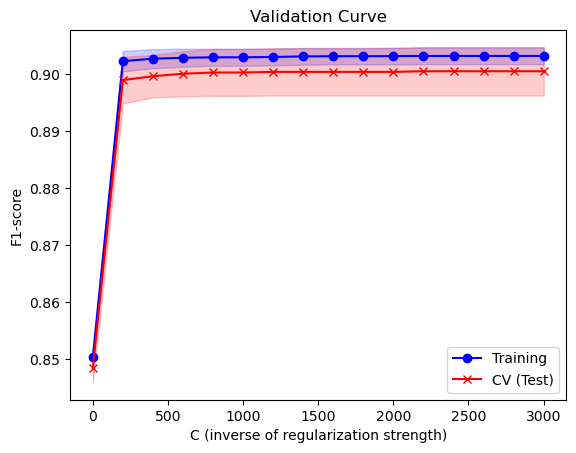

In [8]:
# Plot the result of the different C value
plt.plot(C_range, train_scores_mean, 'o-', label='Training', color='blue')
plt.fill_between(C_range, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, color='blue', alpha=0.2)

plt.plot(C_range, test_scores_mean, 'x-', label='CV (Test)', color='red')
plt.fill_between(C_range, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std, color='red', alpha=0.2)

plt.legend(loc='lower right');plt.ylabel('F1-score');plt.xlabel('C (inverse of regularization strength)');plt.title('Validation Curve');

In [9]:
# Output the C values with the best test scores
best_C_indices = np.argsort(-test_scores_mean)
best_C_values = C_range[best_C_indices]
best_C_values[:5]

array([2201., 2401., 2601., 2801., 3001.])

The best C vlaue is 2201, found in the set of 16.  

### Question 1 Part 2      

Apply best estimator to the test set and obtain the results as well as precision recall curve.  

In [10]:
# Creating logistic regression classifier with L2 regularization
log_reg = LogisticRegression(random_state=42, solver='saga', penalty='l2', max_iter=100000, C=2201)
# Fit the data into the object to create the log_reg model
log_reg.fit(X_ttrain, y_train)

LogisticRegression(C=2201, max_iter=100000, random_state=42, solver='saga')

In [11]:
# Make prediction for building confusion matrix
y_pred = log_reg.predict(X_ttest)

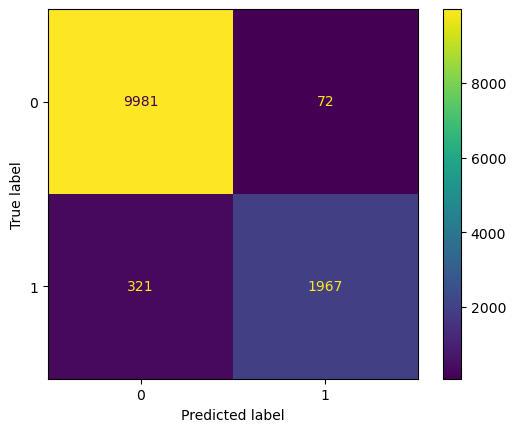

In [12]:
# Show the confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=log_reg.classes_).plot();

In [13]:
# Print the various scores
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     10053
           1       0.96      0.86      0.91      2288

    accuracy                           0.97     12341
   macro avg       0.97      0.93      0.94     12341
weighted avg       0.97      0.97      0.97     12341



Compare with KNN.  

In [14]:
# Create the KNN Classifier used in class
nn20 = KNeighborsClassifier(n_neighbors=20, n_jobs=8)
nn20.fit(X_ttrain, y_train)

KNeighborsClassifier(n_jobs=8, n_neighbors=20)

In [15]:
# Predict the result using KNN
y_knn_pred = nn20.predict(X_ttest)

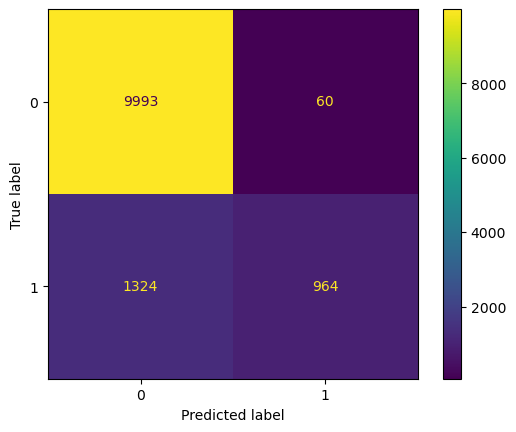

In [16]:
# Print the confusion matrix for KNN
ConfusionMatrixDisplay(confusion_matrix(y_test, y_knn_pred), display_labels=nn20.classes_).plot();

In [18]:
# Print the scores of the KNN
print(classification_report(y_test, y_knn_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.94     10053
           1       0.94      0.42      0.58      2288

    accuracy                           0.89     12341
   macro avg       0.91      0.71      0.76     12341
weighted avg       0.89      0.89      0.87     12341



KNN Classifier (nn20) Performance:  

* The confusion matrix for nn20 shows a higher number of false negatives (1324) compared to log_reg.    
* The classification report shows the following key metrics:   
    * Precision for class 1 is lower (0.84).   
    * Recall for class 1 is significantly lower (0.42), indicating that many positive instances were missed.   
    * The F1 score for class 1 is 0.56, which is quite low compared to its F1 score for class 0 (0.94), suggesting a poorer performance on the minority class.    
    * The overall accuracy is 0.89.   
    
Logistic Regression Classifier (log_reg) Performance:

* The confusion matrix for log_reg shows fewer false negatives (321) and more true positives (1967) compared to nn20.
* The classification report shows the following key metrics:
    * Precision for class 1 is higher (0.96).
    * Recall for class 1 is higher (0.86), indicating that log_reg is better at identifying positive instances.
    * The F1 score for class 1 is 0.91, indicating a better balance between precision and recall compared to nn20.
    * The overall accuracy is higher at 0.97.
    
Why log_reg is Better:

* Higher Recall for Class 1: log_reg is correctly identifying more actual positives than nn20.   
* Higher Precision for Class 1: It is making fewer false positive mistakes for class 1.   
* Higher F1 Score for Class 1: The F1 score balances precision and recall, and a higher F1 score for log_reg suggests it is more robust, especially if class 1 is the minority class or more important for the problem at hand.
* Higher Overall Accuracy: log_reg has a higher overall accuracy, showing it performs better across both classes.

In summary, logistic regression is outperforming the KNN classifier in this particular case, with better performance metrics across the board, indicating it is a better choice for this dataset and problem.

## Question 2

Review the section on 'Running Detections Programmatically' in `08_vision_lecture.ipynb`. Recall that the YOLOv4 model detected 12 objects in `football1.png` and all 12 objects were labeled `person`.

Modify `vision.py` and then use it with the codes in the section on 'Running Detections Programmatically' to detect the objects in `train_station_bournemouth.jpg` and **report all the labels detected and how many objects there were of each label.**

1. In the cell below, include the lines you modify in or/and add to `vision.py` and say where the lines are.
2. Insert other cells after this next cell and fill in the codes you use to detect the objects in `train_station_bournemouth.jpg` and report all the labels detected and how many objects there were of each label.

In [1]:
import myscripts.vision as vs
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import myscripts.download_models as dm
%matplotlib inline
from imgaug import augmenters as iaa
import myscripts.download_models as dm

In [2]:
# Create the neural network object using weights and config from YOLO
nn = cv.dnn.readNet('yolov4.weights', 'yolov4.cfg')
# Read in what can be detected using this set of pretrained weights
with open('object_detection_classes_yolov4.txt', 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

In [3]:
#  Read in image using imread
f1 = cv.imread('../data/train_station_bournemouth.jpg')

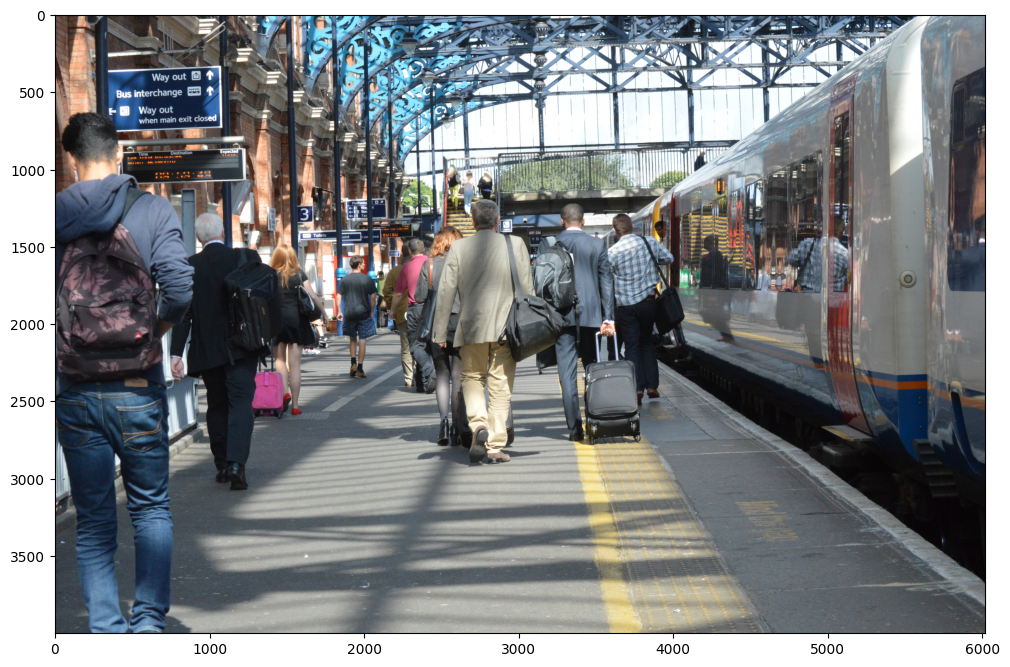

In [4]:
# Display the original image
plt.figure(figsize=(12, 12))
plt.imshow(cv.cvtColor(f1, cv.COLOR_BGR2RGB));

Using the original code provided in lecture 8.

In [5]:
# Pass the image into the pretrained neural network and obtain result
blob = cv.dnn.blobFromImage(f1, size=(416, 416), swapRB=True, ddepth=cv.CV_8U)
nn.setInput(blob, scalefactor=0.00392 )
outs = nn.forward(nn.getUnconnectedOutLayersNames())

In [7]:
import myscripts.vision as vs

In [8]:
# do post processing using code provided
vs.postprocess(f1, outs, classes, nn)

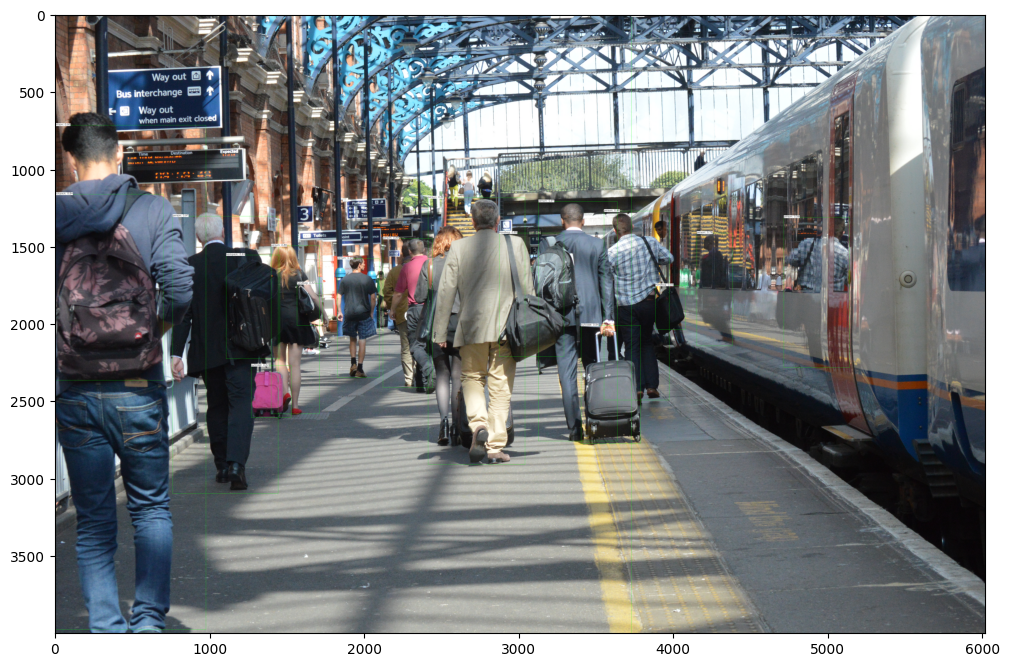

In [9]:
plt.figure(figsize=(12, 12))
plt.imshow(cv.cvtColor(f1, cv.COLOR_BGR2RGB));

### Question 2 Part 1

Modify vision.py and then use it with the codes in the section on 'Running Detections Programmatically' to detect the objects in train_station_bournemouth.jpg and report all the labels detected and how many objects there were of each label.

In the cell below, include the lines you modify in or/and add to vision.py and say where the lines are.

Modifications made:   
1. Made bounding boxes thicker.  
2. Made labels clearer.  
3. For different class, assigned different bounding boxes.  
4. Increased treshold for confidence, to remove some reflections detected.  
5. Added in count dictionary to count number of objects detected by class.

Below is the modified code snippet for `drawPred()` function and `vision_4_assignment.py`:   

```
# Treshold value for confidence of each class is increased.  
confThreshold = 0.6  # Adjust the threshold to a higher value
```

Modified `drawPred()` function to make result more presentable.

```
# Modified drawPred() function
    def drawPred(classId, conf, left, top, right, bottom, bbox_color):
        # Increase border thickness
        border_thickness = 6  # Thick border for high visibility on a high-resolution image

        # Use bbox_color for the bounding box
        cv.rectangle(frame, (left, top), (right, bottom), bbox_color, thickness=border_thickness)

        label = '%.2f' % conf

        # Print a label of class.
        if classes:
            assert(classId < len(classes))
            label = '%s: %s' % (classes[classId], label)
        # Adjust font size and thickness for high-resolution image
        font_scale = 2  # Larger font scale for readability
        label_thickness = 2  # Thicker text for better visibility

        labelSize, baseLine = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, font_scale, label_thickness)
        top = max(top, labelSize[1])

        # Define a different color for the tag
        tag_color = (255, 255, 255)  # White color for the tag

        # Draw the label's background
        cv.rectangle(frame, (left, top - labelSize[1]), (left + labelSize[0], top + baseLine), tag_color, cv.FILLED)

        # Choose a contrasting color for the text
        text_color = (0, 0, 0)  # Black color for the text

        # Draw the text
        cv.putText(frame, label, (left, top), cv.FONT_HERSHEY_SIMPLEX, font_scale, text_color, thickness=label_thickness)
```

The new code also added color palate and a return value, which returns the number of objects found above the treshold for each class.

```
# This is the modified ourput of vision.py, now named vision_4_assignment.py
# This is at the bottom of the code, return vlaue is now added
    # Set counter
    color_dict = {}
    count_dict = {}
    
    for i in indices:
        classId = classIds[i]
        if classId not in color_dict:
            color_dict[classId] = color_palette[len(color_dict) % len(color_palette)]
            count_dict[classes[classId]] = 1
        else:
            count_dict[classes[classId]] += 1
        # Now get the color for the current class_id
        bbox_color = color_dict[classId]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(classId, confidences[i], left, top, left + width, top + height, bbox_color)
        
    return count_dict

```

### Question 2 Part 2

Insert other cells after this next cell and fill in the codes you use to detect the objects in train_station_bournemouth.jpg and report all the labels detected and how many objects there were of each label.

In [10]:
import myscripts.vision_4_assignment as vs4a

In [11]:
f1 = cv.imread('../data/train_station_bournemouth.jpg')
objects=vs4a.postprocess(f1, outs, classes, nn)
print(objects)
for obj in objects:
    print(f"Detected {objects[obj]} {obj}")

{'person': 9, 'train': 1, 'backpack': 2, 'handbag': 1, 'suitcase': 2}
Detected 9 person
Detected 1 train
Detected 2 backpack
Detected 1 handbag
Detected 2 suitcase


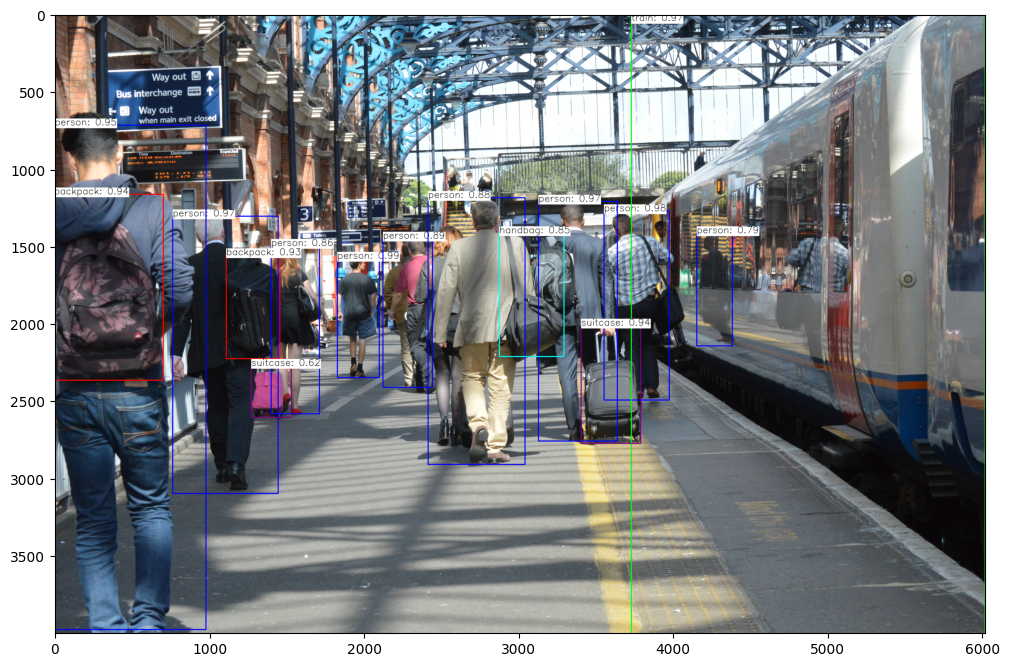

In [12]:
plt.figure(figsize=(12, 12))
plt.imshow(cv.cvtColor(f1, cv.COLOR_BGR2RGB));

## References

1. The Python [pickle module](https://docs.python.org/3/library/pickle.html)
2. More details on logistic regression - see section 4.3 in [this book](https://www.statlearning.com/).
3. sklearn [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) on logistic regression.

In [ ]:
# Complete vision_4_assignment.py
import numpy as np
import cv2 as cv
from IPython.core.debugger import set_trace

def postprocess(frame, outs, classes, yolo):
    # Increase the confidence threshold
    confThreshold = 0.6  # Adjust the threshold to a higher value
    nmsThreshold = 0.4
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    
    def drawPred(classId, conf, left, top, right, bottom, bbox_color):
        # Increase border thickness
        border_thickness = 6  # Thick border for high visibility on a high-resolution image

        # Use bbox_color for the bounding box
        cv.rectangle(frame, (left, top), (right, bottom), bbox_color, thickness=border_thickness)

        label = '%.2f' % conf

        # Print a label of class.
        if classes:
            assert(classId < len(classes))
            label = '%s: %s' % (classes[classId], label)
        # Adjust font size and thickness for high-resolution image
        font_scale = 2  # Larger font scale for readability
        label_thickness = 2  # Thicker text for better visibility

        labelSize, baseLine = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, font_scale, label_thickness)
        top = max(top, labelSize[1])

        # Define a different color for the tag
        tag_color = (255, 255, 255)  # White color for the tag

        # Draw the label's background
        cv.rectangle(frame, (left, top - labelSize[1]), (left + labelSize[0], top + baseLine), tag_color, cv.FILLED)

        # Choose a contrasting color for the text
        text_color = (0, 0, 0)  # Black color for the text

        # Draw the text
        cv.putText(frame, label, (left, top), cv.FONT_HERSHEY_SIMPLEX, font_scale, text_color, thickness=label_thickness)



    layerNames = yolo.getLayerNames()
    lastLayerId = yolo.getLayerId(layerNames[-1])
    lastLayer = yolo.getLayer(lastLayerId)
    
    classIds = []
    confidences = []
    boxes = []
    if lastLayer.type == 'DetectionOutput':
        # Network produces output blob with a shape 1x1xNx7 where N is a number of
        # detections and an every detection is a vector of values
        # [batchId, classId, confidence, left, top, right, bottom]
        for out in outs:
            for detection in out[0, 0]:
                confidence = detection[2]
                if confidence > confThreshold:
                    left = int(detection[3])
                    top = int(detection[4])
                    right = int(detection[5])
                    bottom = int(detection[6])
                    width = right - left + 1
                    height = bottom - top + 1
                    if width <= 2 or height <= 2:
                        left = int(detection[3] * frameWidth)
                        top = int(detection[4] * frameHeight)
                        right = int(detection[5] * frameWidth)
                        bottom = int(detection[6] * frameHeight)
                        width = right - left + 1
                        height = bottom - top + 1
                    classIds.append(int(detection[1]) - 1)  # Skip background label
                    confidences.append(float(confidence))
                    boxes.append([left, top, width, height])
    elif lastLayer.type == 'Region':
        # Network produces output blob with a shape NxC where N is a number of
        # detected objects and C is a number of classes + 4 where the first 4
        # numbers are [center_x, center_y, width, height]
        for out in outs:
            for detection in out:
                scores = detection[5:]
                classId = np.argmax(scores)
                confidence = scores[classId]
                if confidence > confThreshold:
                    center_x = int(detection[0] * frameWidth)
                    center_y = int(detection[1] * frameHeight)
                    width = int(detection[2] * frameWidth)
                    height = int(detection[3] * frameHeight)
                    left = int(center_x - width / 2)
                    top = int(center_y - height / 2)
                    classIds.append(classId)
                    confidences.append(float(confidence))
                    boxes.append([left, top, width, height])
    else:
        print('Unknown output layer type: ' + lastLayer.type)
        exit()

    # NMS is used inside Region layer only on DNN_BACKEND_OPENCV for another backends we need NMS in sample
    # or NMS is required if number of outputs > 1
    outNames = yolo.getUnconnectedOutLayersNames()

    if len(outNames) > 1 or lastLayer.type == 'Region' and args.backend != cv.dnn.DNN_BACKEND_OPENCV:
        indices = []
        classIds = np.array(classIds)
        boxes = np.array(boxes)
        confidences = np.array(confidences)
        unique_classes = set(classIds)
        for cl in unique_classes:
            class_indices = np.where(classIds == cl)[0]
            conf = confidences[class_indices]
            box  = boxes[class_indices].tolist()
            nms_indices = cv.dnn.NMSBoxes(box, conf, confThreshold, nmsThreshold)
            nms_indices = nms_indices[:] if len(nms_indices) else [] # was nms_indices = nms_indices[:, 0] if len(nms_indices) else []
            indices.extend(class_indices[nms_indices])
    else:
        indices = np.arange(0, len(classIds))
    
    # Set color
    color_palette = [
        (255, 0, 0),    # Color for class 0
        (0, 255, 0),    # Color for class 1
        (0, 0, 255),    # Color for class 2
        (255, 255, 0),  # Color for class 3
        (128, 0, 128),  # Color for class 4
        ]
    # Set counter
    color_dict = {}
    count_dict = {}
    
    for i in indices:
        classId = classIds[i]
        if classId not in color_dict:
            color_dict[classId] = color_palette[len(color_dict) % len(color_palette)]
            count_dict[classes[classId]] = 1
        else:
            count_dict[classes[classId]] += 1
        # Now get the color for the current class_id
        bbox_color = color_dict[classId]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(classId, confidences[i], left, top, left + width, top + height, bbox_color)
        
    return count_dict